For citation information, please see the "Source Information" section listed in the associated README file: https://github.com/stephbuon/digital-history/tree/master/hist3368-week6-measuring-change-and-using-groupby

# Week 6: Measuring Change Over Time by Grouping

When working with temporal data, we often want to understand the meaning of some variable -- for instance year or decade.  Understanding often implies using that variable to count other variables, for example: how many times do words appear in each decade?  Which words change over time?
    
In this exercise, we will use two strategies to understand wordcount by period: one is the groupby() command, and the other (which you have seen before) is the "for" loop.  The two essentially do the same thing, but they are used in Python in slightly different contexts.

Before we learn about those strategies, however, let's load some data, put the date column into datetime format, and round it to the nearest month, much as we did above.

### Code example:

The code below is the basic code to load debates from the Stanford database of American Congressional debates.  It takes speeches in one dataframe, and "descriptions" of the speeches (who spoke and when) in another dataframe, and then merges them into one database.

Depending on how the Max and Min Threshold are set, you can ingest more speeches or fewer ones.  If you ingest too many speeches at once, you might crash the computer; but if you're working on an HPC machine, you can always restart the session with more memory and try the exercise again.

In [ ]:
import datetime
import pandas as pd
import numpy as np

In [1]:
import pandas as pd
import csv
import glob

The following lines load some data from Congress. Don't worry too much about the commands within this block; we're more interested in the transformations we'll apply to the data after it's loaded.  If you're curious, the lines below download two separate dataframes --  "speeches" and "descriptions" -- and then merge them  so that we now have one database of speeches with the date on which they were spoken.

In [2]:
all_speech_files = glob.glob('/scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_*.txt')
CONGRESS_MIN_THRESHOLD = 100
CONGRESS_MAX_THRESHOLD = 115

speech_files = []

for fn in all_speech_files:
    number = int(fn.rsplit('_', 1)[-1].split('.')[0])
    if CONGRESS_MIN_THRESHOLD <= number <= CONGRESS_MAX_THRESHOLD:
        speech_files.append(fn)

speech_files.sort()
        
def parse_one(fn):
    print(f'Reading {fn}...')
    return pd.read_csv(fn, sep='|', encoding="ISO-8859-1", error_bad_lines=False, warn_bad_lines=False, quoting=csv.QUOTE_NONE)

speeches_df = pd.concat((parse_one(fn) for fn in speech_files))
speeches_df.dropna(how='any', inplace=True)

all_description_files = glob.glob('/scratch/group/oit_research_data/stanford_congress/hein-bound/descr_*.txt')
                                  
description_files = []

for fn in all_description_files:
    number = int(fn.rsplit('_', 1)[-1].split('.')[0])
    if CONGRESS_MIN_THRESHOLD <= number <= CONGRESS_MAX_THRESHOLD:
        description_files.append(fn)
        description_files.sort()
        
description_df = pd.concat((parse_one(fn) for fn in description_files))

all_data = pd.merge(speeches_df, description_df, on = 'speech_id')
all_data.fillna(0, inplace=True)
all_data.head()

Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_100.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_101.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_102.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_103.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_104.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_105.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_106.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_107.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_108.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_109.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_110.txt...
Reading /s

,speech_id,speech,chamber,date,number_within_file,speaker,first_name,last_name,state,gender,line_start,line_end,file,char_count,word_count
0,1000000001,Representativeselect to the 100th Congress. th...,H,19870106,1,The CLERK,Unknown,Unknown,Unknown,Special,57,82,01061987.txt,851,136
1,1000000002,The Chair would also like to state that Repres...,H,19870106,2,The CLERK,Unknown,Unknown,Unknown,Special,84,88,01061987.txt,142,26
2,1000000003,The quor closes that 426 Represe have answered...,H,19870106,3,The CLERK,Unknown,Unknown,Unknown,Special,536,539,01061987.txt,73,13
3,1000000004,The Clerk credentials regular in for received ...,H,19870106,4,The CLERK,Unknown,Unknown,Unknown,Special,541,552,01061987.txt,253,43
4,1000000005,The next order of business is the election of ...,H,19870106,5,The CLERK,Unknown,Unknown,Unknown,Special,554,580,01061987.txt,376,65


Let's clean up the data a little by deleting columns we won't use in this exercise.   The general command is 

        df.drop('colname', axis)
        
        
Axis is '1' if you're deleting normal columns (not rows).

In [3]:
all_data = all_data.drop(['chamber', 'speech_id', 'number_within_file', 'first_name'], 1)
all_data = all_data.drop(['last_name', 'state', 'gender', 'line_start', 'line_end', 'file', 'char_count'], 1)

In [4]:
all_data.head()

,speech,date,speaker,word_count
0,Representativeselect to the 100th Congress. th...,19870106,The CLERK,136
1,The Chair would also like to state that Repres...,19870106,The CLERK,26
2,The quor closes that 426 Represe have answered...,19870106,The CLERK,13
3,The Clerk credentials regular in for received ...,19870106,The CLERK,43
4,The next order of business is the election of ...,19870106,The CLERK,65


Now that we have the data in place, let's ask the data: when does it stop or start?

In [5]:
max(all_data['date'])

20101222

The last date is listed above -- year first, then month, then day.

In [6]:
min(all_data['date'])

19870106

Whoops, that's not right.  I bet there are some zeros in the date data for speeches that haven't been assigned a date.  Let's get rid of that data before it messes up our other counts!

Use datetime to render the date column as recognizable dates

In [7]:
all_data['date']=pd.to_datetime(all_data['date'],format='%Y%m%d')
all_data.head()

,speech,date,speaker,word_count
0,Representativeselect to the 100th Congress. th...,1987-01-06,The CLERK,136
1,The Chair would also like to state that Repres...,1987-01-06,The CLERK,26
2,The quor closes that 426 Represe have answered...,1987-01-06,The CLERK,13
3,The Clerk credentials regular in for received ...,1987-01-06,The CLERK,43
4,The next order of business is the election of ...,1987-01-06,The CLERK,65


Notice how the results are different after we use pd.to_datetime():

In [8]:
max(all_data['date'])

Timestamp('2010-12-22 00:00:00')

In [9]:
min(all_data['date'])

Timestamp('1987-01-06 00:00:00')

In [10]:
all_data['year'] = pd.to_datetime(all_data['date']).dt.year

all_data.head()

,speech,date,speaker,word_count,year
0,Representativeselect to the 100th Congress. th...,1987-01-06,The CLERK,136,1987
1,The Chair would also like to state that Repres...,1987-01-06,The CLERK,26,1987
2,The quor closes that 426 Represe have answered...,1987-01-06,The CLERK,13,1987
3,The Clerk credentials regular in for received ...,1987-01-06,The CLERK,43,1987
4,The next order of business is the election of ...,1987-01-06,The CLERK,65,1987


In [11]:
all_data['month']= pd.to_datetime(all_data['date']).dt.month
all_data.tail()

,speech,date,speaker,word_count,year,month
2643096,Madam Speaker. on rollcall Nos. 662 and 661. I...,2010-12-22,Ms. GRANGER,23,2010,12
2643097,Madam Speaker. as I leave Congress as the peop...,2010-12-22,Ms. KILPATRICK of Michigan,221,2010,12
2643098,Madam Speaker. on rolicall No. 658. I was unav...,2010-12-22,Mr. HELLER,19,2010,12
2643099,Madam Speaker. on rollcall No. 658 my flight w...,2010-12-22,Mr. PAULSEN,23,2010,12
2643100,Madam Speaker. I wold like to submit the follo...,2010-12-22,Mr. HALL of New York,446,2010,12


Notice that the available fields above are the full date time -- which tells us even the minute, when we look closely (by using max() for example), and year.  But I'd like us to be able to count the top words per month. Let's use our "period" command to floor every date to the nearest month, creating a new column called "month_year." 

Look at the data table below to make sure you understand what the new column looks like.

In [12]:
# create a period variable called month_year
all_data['month_year'] = pd.to_datetime(all_data['date']).dt.to_period('M')
all_data.head()

,speech,date,speaker,word_count,year,month,month_year
0,Representativeselect to the 100th Congress. th...,1987-01-06,The CLERK,136,1987,1,1987-01
1,The Chair would also like to state that Repres...,1987-01-06,The CLERK,26,1987,1,1987-01
2,The quor closes that 426 Represe have answered...,1987-01-06,The CLERK,13,1987,1,1987-01
3,The Clerk credentials regular in for received ...,1987-01-06,The CLERK,43,1987,1,1987-01
4,The next order of business is the election of ...,1987-01-06,The CLERK,65,1987,1,1987-01


Next, we're going to convert the period column that we just created -- month_year -- back to date format (it's now in datetime's special "month-year" format). This is basically an issue that we're dealing with now so that our graphics work later.  Matplotlib knows what to do with full dates, but it doesn't know what to do with "month-year" format. You don't need to understand the following line of code, but you need to know that sometimes converting periods back to datetime format will resolve graphics issues.

In [13]:
# convert month-year back to date format for easier plotting later (this normalizes the field to a kind of date that matplotlib likes)
all_data['month_year'] =all_data.month_year.values.astype('datetime64[M]')
all_data.head()

,speech,date,speaker,word_count,year,month,month_year
0,Representativeselect to the 100th Congress. th...,1987-01-06,The CLERK,136,1987,1,1987-01-01
1,The Chair would also like to state that Repres...,1987-01-06,The CLERK,26,1987,1,1987-01-01
2,The quor closes that 426 Represe have answered...,1987-01-06,The CLERK,13,1987,1,1987-01-01
3,The Clerk credentials regular in for received ...,1987-01-06,The CLERK,43,1987,1,1987-01-01
4,The next order of business is the election of ...,1987-01-06,The CLERK,65,1987,1,1987-01-01


In [14]:
# list all unique month_years
set(all_data['month_year'])

{Timestamp('1987-01-01 00:00:00'),
 Timestamp('1987-02-01 00:00:00'),
 Timestamp('1987-03-01 00:00:00'),
 Timestamp('1987-04-01 00:00:00'),
 Timestamp('1987-05-01 00:00:00'),
 Timestamp('1987-06-01 00:00:00'),
 Timestamp('1987-07-01 00:00:00'),
 Timestamp('1987-08-01 00:00:00'),
 Timestamp('1987-09-01 00:00:00'),
 Timestamp('1987-10-01 00:00:00'),
 Timestamp('1987-11-01 00:00:00'),
 Timestamp('1987-12-01 00:00:00'),
 Timestamp('1988-01-01 00:00:00'),
 Timestamp('1988-02-01 00:00:00'),
 Timestamp('1988-03-01 00:00:00'),
 Timestamp('1988-04-01 00:00:00'),
 Timestamp('1988-05-01 00:00:00'),
 Timestamp('1988-06-01 00:00:00'),
 Timestamp('1988-07-01 00:00:00'),
 Timestamp('1988-08-01 00:00:00'),
 Timestamp('1988-09-01 00:00:00'),
 Timestamp('1988-10-01 00:00:00'),
 Timestamp('1989-01-01 00:00:00'),
 Timestamp('1989-02-01 00:00:00'),
 Timestamp('1989-03-01 00:00:00'),
 Timestamp('1989-04-01 00:00:00'),
 Timestamp('1989-05-01 00:00:00'),
 Timestamp('1989-06-01 00:00:00'),
 Timestamp('1989-07-

Notice that, even though we have a full datetime stamp for that column, there's only one date listed per month and per year.  This means that March 26, 2010 has been rounded to 2010-03-01, and will be grouped with March 22 and March 15 of 2010.  

Now that we have a standardize month_year variable, we can ask the computer to group all words that were spoken in that month together and measure how many words, total, were spoken in that month.  

To count all the words spoken in every month_year, we'll need a new tool from pandas: groupby(). 

# The Pandas `groupby()` Method

Understanding how to group data is essential for performing a number of operations on pandas DataFrames. 

Groupby refers to a process involving one or more of the following steps: 
 - splitting the data into groups based on some criteria.
 - applying a function to each group independently.
 - combining the results into a data structure. 

The main takeaway is that with `groupby()` we can group categories and then apply functions to the categories instead of to the entire data set.

Before showing code examples of `groupby()` let's get a quick conceptual overview of what it means to perform a function to a category as opposed to the entire data set.

Consider the following image, a sample of the Hansard data. If we were to group this data by decade it would be as though we stuck each decade into a bucket to be operated upon independantly from the rest of the data.

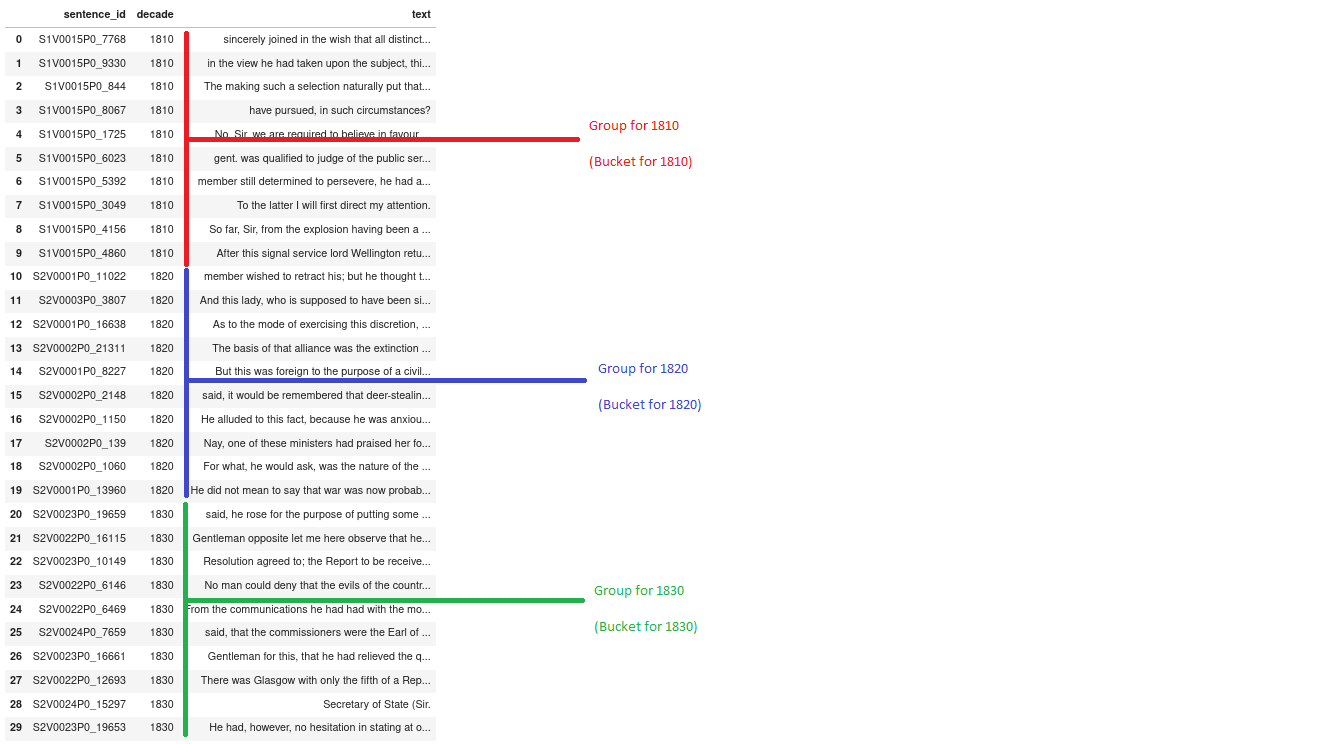

The following code example demonstrates this concept in action. During this example we will:

1. Count the number of words in each sentence of our Hansard sample
2. Group the data by decade
3. Sum the total number of words per each decade based on our sentence-level word counts

### Groupby in Action

Let me try to translate groupby() into plain English.  Imagine that I'm counting easter eggs.  I can count all of my eggs together, and I get one number.  

But what if I want to count all of the green eggs, the red eggs, and the yellow eggs, and have separate counts for each?  Let's say, to make things easy, I sort the eggs by color, putting each color of eggs into a unique basket.  Now I have a basked of red eggs, and if I count all of the eggs in the basket, I know how many red eggs there are. 

Groupby() is like having a series of baskets.  

Groupby() tells the computer to "group" your data by some variable (in the case of my example, you're "grouping" eggs by "color") before you apply any other function, for example, counting them.  

With groupby(), the computer can count all the words per date or words per speaker.

Without groupby(), all the computer knows how to do is to count everything -- like someone who can only count the total number of eggs, but not the number of red eggs and yellow eggs separately. 

---

Groupby() is a function that takes as its argument the column that you are grouping the data by.  

If we were counting eggs, we would groupby(['egg_color']).

Because we are counting words per month, we will group_by(['month_year']).

Notice please that the name of the column is in both brackets [] and single quotation marks ''.  The brackets tell Python that you are want part of the dataframe WHICH corresponds to an index.  The quotation marks tell Python that you want the column of the dataframe that corresponds to the string 'month_year.'

----

Groupby() is usually strung along with another command -- which tells Python what to do with the data once you group it. In this case, we want to total the number of words, so we will string together .groupby().sum().

Groupby() is also typically followed by a command that says that Python should create a new database with the grouped data: .copy().  Without `.copy`, the new variable you create is actually a reference to the original data frame, not a new subset that just contains word_count. You don't need to understand why, but you should know that this convention will help your data to retain its integrity.  Use .groupby().sum().copy().

In [15]:
words_per_month_counts = all_data.groupby(['month_year']).sum()
#words_per_month_counts = all_data.groupby(['month_year'], as_index = False).agg({'word_count': sum})

In [16]:
words_per_month_counts

,word_count,year,month
month_year,,,
1987-01-01,1186313,10823189,5447
1987-02-01,1025105,9370692,9432
1987-03-01,1996218,20283296,30624
1987-04-01,1958265,22947863,46196
1987-05-01,2194226,30907785,77775
...,...,...,...
2010-08-01,360153,3358710,13368
2010-09-01,1336598,14178540,63486
2010-10-01,523,36180,180


If you're wondering what happened, you might scroll up to the last instance of the table and notice that there was already a word_count column that had the number of words in every speech.  There were many speeches per month_year.  

In the new word_count column, we have put all the speeches that happened in a single month_year into one basket.  For each basket, we have added together all of the word_count numbers from the individual speeches.  

The sum of all the word_count numbers is the number of words that were spoken in every month.

See for yourself -- look at the table above and notice that the word_count column numbers are around 100 words per speech.  Look at the word_count column in words_per_month_counts, and see that the word_count column is closer to 1 or 2 million in many cases.

We have grouped the data by month and taken a count.  .groupby().sum().copy().

--



Next, let's play with making our dataframe more elegant.

Let's say that we only want to look at one column here -- word_count.  

We use double backets to select the column from the dataframe, while keeping the data classified as a dataframe (not a series object), because dataframes are more flexible.  For more on dataframes and series objects, see  https://www.educative.io/edpresso/series-vs-dataframe-in-pandas. 

Again, you don't really need to know about dataframes vs. series objects, but you should remember that square brackets will be more flexible when we're working with tabular data in pandas.

In [17]:
just_counts = words_per_month_counts[['word_count']].copy() 
just_counts

,word_count
month_year,
1987-01-01,1186313
1987-02-01,1025105
1987-03-01,1996218
1987-04-01,1958265
1987-05-01,2194226
...,...
2010-08-01,360153
2010-09-01,1336598
2010-10-01,523


You'll notice that the month_year column is in bold.

By putting the month_year column in bold, pandas is telling us that it used the month_year column to "group" the other data.

Technically, the month_year column is an "index" -- we might also call it a 'grouping' or a 'label' -- not just another column of data.

But we're going to want to treat month_year like another kind of data soon.  We're going to want to put it on the x axis.  So we need to take month_year out of "index" format and make it into a column.  This process is called "resetting the index."  Again you don't need to know much about what's being done, but you need to notice that resetting the index can solve the problem of working with the data that was the "group" after you run a groupby() command.   

In [18]:
just_counts.reset_index(level=0, inplace=True)
display(just_counts)

,month_year,word_count
0,1987-01-01,1186313
1,1987-02-01,1025105
2,1987-03-01,1996218
3,1987-04-01,1958265
4,1987-05-01,2194226
...,...,...
266,2010-08-01,360153
267,2010-09-01,1336598
268,2010-10-01,523
269,2010-11-01,665953


Just_counts is a dataframe grouped by month_year with column word_count.  It's perfect for showing change over time.

If we wanted to start the whole process over again, and count by year, we could do that by first extracting the year column. 

Then we'd groupby() year and sum() and copy().

In [19]:
just_counts['year'] = pd.to_datetime(just_counts['month_year']).dt.year # now we can make a column for just the year 

display(just_counts)

,month_year,word_count,year
0,1987-01-01,1186313,1987
1,1987-02-01,1025105,1987
2,1987-03-01,1996218,1987
3,1987-04-01,1958265,1987
4,1987-05-01,2194226,1987
...,...,...,...
266,2010-08-01,360153,2010
267,2010-09-01,1336598,2010
268,2010-10-01,523,2010
269,2010-11-01,665953,2010


What if we wanted to find the top words per year?

First, we'd make sure there was a year column in all_data.

In [20]:
all_data['year'] = pd.to_datetime(all_data['month_year']).dt.year 
all_data

,speech,date,speaker,word_count,year,month,month_year
0,Representativeselect to the 100th Congress. th...,1987-01-06,The CLERK,136,1987,1,1987-01-01
1,The Chair would also like to state that Repres...,1987-01-06,The CLERK,26,1987,1,1987-01-01
2,The quor closes that 426 Represe have answered...,1987-01-06,The CLERK,13,1987,1,1987-01-01
3,The Clerk credentials regular in for received ...,1987-01-06,The CLERK,43,1987,1,1987-01-01
4,The next order of business is the election of ...,1987-01-06,The CLERK,65,1987,1,1987-01-01
...,...,...,...,...,...,...,...
2643096,Madam Speaker. on rollcall Nos. 662 and 661. I...,2010-12-22,Ms. GRANGER,23,2010,12,2010-12-01
2643097,Madam Speaker. as I leave Congress as the peop...,2010-12-22,Ms. KILPATRICK of Michigan,221,2010,12,2010-12-01
2643098,Madam Speaker. on rolicall No. 658. I was unav...,2010-12-22,Mr. HELLER,19,2010,12,2010-12-01
2643099,Madam Speaker. on rollcall No. 658 my flight w...,2010-12-22,Mr. PAULSEN,23,2010,12,2010-12-01


Then, we'd groupby().sum().copy() with the year column instead.  

We'd select just the word_count column, as before...

... and reset the index

In [21]:
word_per_year_counts = all_data.groupby(['year']).sum().copy() 

per_year_counts = word_per_year_counts[['word_count']].copy()

per_year_counts.reset_index(level=0, inplace=True)

per_year_counts

,year,word_count
0,1987,23052012
1,1988,19841019
2,1989,19331541
3,1990,22220951
4,1991,22644140
5,1992,20491892
6,1993,21334446
7,1994,19902867
8,1995,29212581
9,1996,18559347


Out of curiosity, what was the maximum number of words spoken in Congress per year?

In [22]:
max(per_year_counts['word_count'])

29212581

What if I want to know what year that was?  I can use .query(), and specify in the parentheses the factors I'm trying to match.  

In the brackets that follow, I can specify what column I want to look up.  

In [23]:
per_year_counts.query('word_count==29212581')['year']

8    1995
Name: year, dtype: int64

The maximum number of words per year happened in 1995.

## Graphing Wordcount Over Time

Now let's represent change over time by graphing the counts over months. 

Sometimes it's useful when working with dates to create an 'index' for the dataframe, which in this case will be used by matplotlib to decide which dates will be labeled.

In [24]:
import matplotlib.pyplot as plt

%matplotlib inline

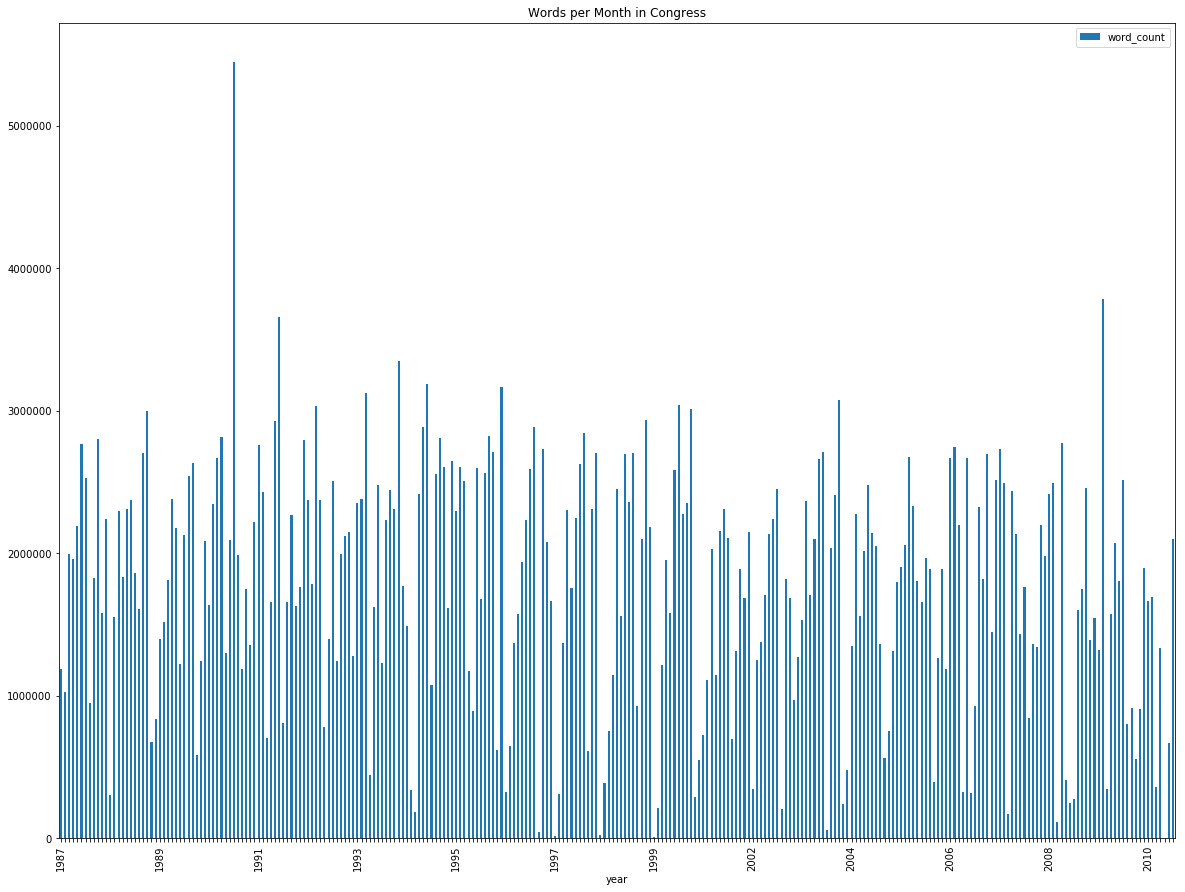

In [25]:

plt.rcParams['figure.figsize'] = [20, 15] # make the vis larger so it's easier to see 

a = just_counts.plot.bar(x = "year", y = "word_count", title = "Words per Month in Congress") # assign columns from the panda's DataFrame to the X and Y axis. 

# the following code makes all tick labels invisible, and then makes visible
# every 12th (since there are 12 months in a year)

plt.setp(a.get_xticklabels()[::1], visible=False)
plt.setp(a.get_xticklabels()[::24], visible=True)

a

In this representation we can see that there's a lot of variation of how much Congress spoke and when.   Notice that there's a huge amount of variation -- from almost nothing to quite a lot.  These variations can create trouble for us if we aren't careful!

# Apply What You've Learned: Searching for a Controlled Vocabulary Over Time

Next, we're going to execute the same process of using groupby() again, combining it with the skills we've already learned.  

We'll clean the data and get the most frequent words.

Then we'll use groupby(), this time to count by *speaker*.  

Instead of simply using .groupby().sum().copy() to find the counts of *all* the words, we'll combine groupby() with another function -- str.count() -- to find out how many time speakers used the word "democracy."

We'll find the top five speakers.


## Break speeches into words, get the most frequent words

Next, let's filter for just the speeches from the 1980s.  

First, we need to make a 'year' column.

Then we need to filter for years that are in our target.  Note the use of the .isin() function. 

In [26]:
target_years = list(range(1980, 1989 + 1))  # List of the years 1980-1989

all_data['year']=pd.to_datetime(all_data['date']).dt.year # make a year column

eighties_data = all_data[all_data['year'].isin(target_years)].copy()  # filter our dataset to just this decade

In [27]:
eighties_data.head()

,speech,date,speaker,word_count,year,month,month_year
0,Representativeselect to the 100th Congress. th...,1987-01-06,The CLERK,136,1987,1,1987-01-01
1,The Chair would also like to state that Repres...,1987-01-06,The CLERK,26,1987,1,1987-01-01
2,The quor closes that 426 Represe have answered...,1987-01-06,The CLERK,13,1987,1,1987-01-01
3,The Clerk credentials regular in for received ...,1987-01-06,The CLERK,43,1987,1,1987-01-01
4,The next order of business is the election of ...,1987-01-06,The CLERK,65,1987,1,1987-01-01


Next, clean the words. Note that you have seen .str.lower() and .str.replace() before. 

In [28]:
eighties_data['speech'] = eighties_data['speech'].str.lower() #lowercase
eighties_data['speech']  = eighties_data['speech'].str.replace('[^\w\s]','') # remove punctuation

Next, we're going to break speeches into words and remove stopwords.  We get our stopwords list from the package NLTK (natural language toolkit):

In [29]:
import nltk
from nltk.corpus import stopwords

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/dbalut/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
stop = stopwords.words('english')
stop[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

We remove the stopwords with a nested loop that moves through the dataframe above.  Here's a detailed account of what the following for-loop does to remove stopwords from the column 'speech' in the dataframe 'eighties_data2'.

* Before we do anything else, we create a backup of eighties_data (just in case we mangle things!) and we make an empty list called new_column, which is going to be a dummy version of the real data in eighties_data['speech']


        eighties_data2 = eighties_data.copy()

        new_column = []
        
        
* The first part of the loop takes the 'speech' column, and moves one row at a time:
    
        'for speech in eighties_data2['speech']'
        

* Next, the instructions split up each given speech into a list of separate words, which we call 'speech1'  
    
        'speech1 = speech.split()'


* Next, we create an empty dummy variable called 'speech2':

        speech2 = []


* We move through the words of speech1, asking of each one: Is this word in the stopwords list, 'stop'?

        for word in speech1:
            if word not in stop:
                
                
* If the word is NOT a stopword, we're going to keep it and add it to our dummy variable, speech2.  

                speech2.append(word)
                

* After that loop runs through every words in speech1, we will have a version of the first speech from eighties_data2['speech'] that has no stopwords, and we've called it speech2.  

    It's currently in the form of a list, so we're going to weld it back into a string with .join():
    
                speech3 = ' '.join(speech2)


* Then, at last, we'll tack our stopworded speech (speech3) onto the end of our dummy list, new_column.
                    
                 new_column.append(speech3)


The loop repeats this process for every speech in eighties_data2['speech'], and every word in every speech.  At the end of that process, new_column will be a list of clean speeches in the same order as the original column.

*  All there is to do now is to take our stopworded handiwork -- new_column -- and use it to replace the unstopworded original column, eighties_data2['speech']:
            
        eighties_data2['speech'] = new_column

The new output, eighties_data2, should be just like eighties_data, but with stopwords removed in the 'speech' column.

Please note that the below loop takes a minute to run.  *Also of interest for advanced coders: there are many ways to do this in parallel, using .apply(). We won't be covering them in this class, but you should feel free to look them up and implement them if you feel competent on your own.

In [32]:
eighties_data2 = eighties_data.copy()

new_column = []

for speech in eighties_data2['speech']:
    speech1 = speech.split()
    speech2 = []
    for word in speech1:
        if word not in stop:
            speech2.append(word)
    speech3 = ' '.join(speech2)
    new_column.append(speech3)

new_column

eighties_data2['speech'] = new_column

eighties_data2.head()

,speech,date,speaker,word_count,year,month,month_year
0,representativeselect 100th congress day fixed ...,1987-01-06,The CLERK,136,1987,1,1987-01-01
1,chair would also like state representativesele...,1987-01-06,The CLERK,26,1987,1,1987-01-01
2,quor closes 426 represe answered thei quorum p...,1987-01-06,The CLERK,13,1987,1,1987-01-01
3,clerk credentials regular received showing el ...,1987-01-06,The CLERK,43,1987,1,1987-01-01
4,next order business election speaker house rep...,1987-01-06,The CLERK,65,1987,1,1987-01-01


Another way of doing the same thing is with the .str.replace() function.

str.replace() takes two arguments: (OLD, NEW)
    
In the lines of code below, we create a "regular expression" that looks for the stopwords:
    
            pat = r'\b(?:{})\b'.format('|'.join(stop))
            
To break that down a little: "r'\b(?:{})\b'" means, "look for a word boundary or any punctuation."  "|" means "or" -- search for "is" OR "in" OR "to" OR "with", etc., not ALL of them.  .join(stop) brings in our list of stopwords and tells the regular expression to look for every stopword in the list.  You don't need to master regular expressions -- which are a pain -- but knowing where to find a regular expression like this and having some ideas about how to tweak it will give you a nice tool to use if you need to search for any other lists of words.

Then weuse str.replace to REPLACE any instances of the stopwords with '', or nothing:

            eighties_data2['speech'] = eighties_data2['speech'].str.replace(pat, '')
            
            
Note please that this produces exactly the same results as the code above.


In [33]:
pat = r'\b(?:{})\b'.format('|'.join(stop))
eighties_data2['speech'] = eighties_data['speech'].str.replace(pat, '')
eighties_data2.head()

,speech,date,speaker,word_count,year,month,month_year
0,representativeselect 100th congress day f...,1987-01-06,The CLERK,136,1987,1,1987-01-01
1,chair would also like state representatives...,1987-01-06,The CLERK,26,1987,1,1987-01-01
2,quor closes 426 represe answered thei quor...,1987-01-06,The CLERK,13,1987,1,1987-01-01
3,clerk credentials regular received showing ...,1987-01-06,The CLERK,43,1987,1,1987-01-01
4,next order business election speaker h...,1987-01-06,The CLERK,65,1987,1,1987-01-01


Please note (this will be important later): If we wanted, instead, to count the *presence* of the stopwords or other certain words, we could use a related command, 

        str.count()
        
        
Check it out:

In [35]:
eighties_data2['stopwords'] = eighties_data.speech.str.count(pat)  

In this example, we're creating a column that counts ALL the stopwords that were removed from every speech.  But we could also write a loop that would create a column for each word in a list of a controlled vocabulary.

In [36]:
eighties_data2.head()

,speech,date,speaker,word_count,year,month,month_year,stopwords
0,representativeselect 100th congress day f...,1987-01-06,The CLERK,136,1987,1,1987-01-01,69
1,chair would also like state representatives...,1987-01-06,The CLERK,26,1987,1,1987-01-01,13
2,quor closes 426 represe answered thei quor...,1987-01-06,The CLERK,13,1987,1,1987-01-01,5
3,clerk credentials regular received showing ...,1987-01-06,The CLERK,43,1987,1,1987-01-01,12
4,next order business election speaker h...,1987-01-06,The CLERK,65,1987,1,1987-01-01,26


Going back to our stopworded speech column for a moment -- let's count the top words.  

Let's create a list called "all_words" from the content of each speech in the "speech" column.

In [37]:
eighties_words = []

for speech in eighties_data2['speech']:
    speech1 = speech.split()
    for word in speech1:
        eighties_words.append(word)
        

In [38]:
eighties_words[:10]

['representativeselect',
 '100th',
 'congress',
 'day',
 'fixed',
 '20th',
 'amendment',
 'constitution',
 'public',
 'law']

Then we'll apply the "Counter" command to count the words.  

In [39]:
from collections import Counter

In [40]:
mycount = Counter(eighties_words)

top_words = mycount.most_common(20)

top_words

[('mr', 388908),
 ('would', 260668),
 ('president', 230906),
 ('bill', 198986),
 ('amendment', 156503),
 ('us', 146361),
 ('senator', 144134),
 ('time', 140473),
 ('speaker', 122243),
 ('one', 120267),
 ('committee', 117139),
 ('states', 111609),
 ('gentleman', 110625),
 ('people', 102336),
 ('years', 100414),
 ('new', 99459),
 ('senate', 98810),
 ('chairman', 94505),
 ('congress', 91998),
 ('year', 89574)]

Great -- but some of those words are pretty hollow!  

Let's create a new stopword list and clean it up.

In [41]:
stopworded_count = []
stopwords2 = ['ca', 'mr', 'many', 'without', 'last', 'way', 'programs', 'want', 'like', 'ask', 'could', 'year', 'american', 'country', 'well', 'made', 'say', 'members', 'million', 'must', 'percent', 'congress', 'federal', 'national', 'legislation', 'government', 'program', 'may', 'act', 'make', 'going', 'first', 'senator', 'senate', 'legislation', 'support', 'chairman', 'amendment', 'committee', 'united', 'today', 'state', 'one', 'us', 'gentleman', 'would', 'bill', '100th', 'house', 'states', 'new', 'speaker', 'years', 'also', 'time']

eighties_words2 = []

for speech in eighties_data2['speech']:
    speech1 = speech.split()
    for word in speech1:
        if word not in stopwords2: # notice the new line here!
            eighties_words2.append(word)
        
mycount2 = Counter(eighties_words2)

In [42]:
top_words2 = mycount2.most_common(20)

top_words2

[('president', 230906),
 ('people', 102336),
 ('think', 79252),
 ('yield', 63796),
 ('colleagues', 62844),
 ('work', 56482),
 ('important', 55300),
 ('budget', 54344),
 ('vote', 53250),
 ('law', 52743),
 ('public', 52117),
 ('know', 51671),
 ('take', 50378),
 ('believe', 48183),
 ('resolution', 48068),
 ('need', 46873),
 ('order', 44036),
 ('care', 44016),
 ('get', 43959),
 ('world', 43171)]

## Get the top 5 speakers of the word "democracy" for a given decade

In [43]:
import numpy as np

Next, let's count the number of times that the word 'democracy' appears in the 1980s.  

Notice the use of .str.count():

In [44]:
eighties_data['democracy_count'] = eighties_data['speech'].str.count('democracy')  # Create a new column for the count of the word democracydis
display(eighties_data)

,speech,date,speaker,word_count,year,month,month_year,democracy_count
0,representativeselect to the 100th congress thi...,1987-01-06,The CLERK,136,1987,1,1987-01-01,0
1,the chair would also like to state that repres...,1987-01-06,The CLERK,26,1987,1,1987-01-01,0
2,the quor closes that 426 represe have answered...,1987-01-06,The CLERK,13,1987,1,1987-01-01,0
3,the clerk credentials regular in for received ...,1987-01-06,The CLERK,43,1987,1,1987-01-01,0
4,the next order of business is the election of ...,1987-01-06,The CLERK,65,1987,1,1987-01-01,0
...,...,...,...,...,...,...,...,...
390356,mr speaker i rise today to honor mr a john bri...,1989-11-21,Mr. McMILLEN of Maryland,298,1989,11,1989-11-01,0
390357,mr speaker i am very pleased to offer my congr...,1989-11-21,Mr. WYDEN,853,1989,11,1989-11-01,0
390358,mr speaker tommy gaspar became a scout in troo...,1989-11-21,Mr. BRENNAN,251,1989,11,1989-11-01,0
390359,mr speaker at the end of this year the departm...,1989-11-21,Mr. MONTGOMERY,325,1989,11,1989-11-01,0


Next, let's use groupby() to "group" by speaker, using the 'speaker' column.  

We'll use .groupby().aggregate({‘new_column_name’: np.sum}) to do the same thing — where new_column name is the new name of the column.  

In [45]:
eighties_data_grouped = eighties_data.groupby('speaker').aggregate({'democracy_count': np.sum})  # Sum the rows by democracy_count
eighties_data_grouped

,democracy_count
speaker,
ALS. JUNE,0
ANS. HUMAN RIGHTS COMMISSION,0
ANS. MATTIHEW,0
APR. I AND JUNE,0
Ar. DOLE],0
...,...
ver. U.S,0
ver. U.S. officials,0
war. U.S,0


Looks like there are a lot of speakers who never mention democracy!

Let's use the .nlargest() command to find the 5 speakers who talked about democracy the most.

In [46]:
democracy_speakers = eighties_data.nlargest(n=5, columns=['democracy_count'])
democracy_speakers

,speech,date,speaker,word_count,year,month,month_year,democracy_count
233630,mr president in listening to the speeches toda...,1988-08-10,Mr. PACKWOOD,5661,1988,8,1988-08-01,27
24954,mr speaker with its four core grantees the nat...,1987-04-09,Mr. CONIMS,1603,1987,4,1987-04-01,26
364248,mr president benazir bhutto prime minister of ...,1989-10-13,Mr. KERRY,2162,1989,10,1989-10-01,24
290330,mr president i wanted to say to my friend from...,1989-04-13,Mr. WALLOP,1213,1989,4,1989-04-01,19
8741,madam president i support this resolution expr...,1987-02-19,Mr. KERRY,1296,1987,2,1987-02-01,18


## Get the top 5 longest speeches of a particular speaker

Let's play with the data some more.  

What if we want to get all the speeches by the speakers who spoke the most about democracy?

First, we'll filter (notice the double square brackets) to extract the index names (the row names -- remember?) from the democracy_speakers dataframe.

In [47]:
top_speaker = democracy_speakers[['speaker']]
top_speaker

,speaker
233630,Mr. PACKWOOD
24954,Mr. CONIMS
364248,Mr. KERRY
290330,Mr. WALLOP
8741,Mr. KERRY


Next, we'll return to the 1980s data in eighties_data, but find only the speeches where the name in the 'speaker' column matches the list called top_speaker.

In [48]:
top_speaker_speeches = eighties_data[eighties_data['speaker'].isin(top_speaker['speaker'])] # Filter for only this specific speaker's speeches
top_speaker_speeches 

,speech,date,speaker,word_count,year,month,month_year,democracy_count
366,mr president i am pleased to rise today as a c...,1987-01-06,Mr. KERRY,585,1987,1,1987-01-01,0
746,mr president one of the most significant accom...,1987-01-06,Mr. KERRY,778,1987,1,1987-01-01,0
747,mr president i want to express my strong suppo...,1987-01-06,Mr. KERRY,677,1987,1,1987-01-01,3
748,mr president for years those of us from the no...,1987-01-06,Mr. KERRY,166,1987,1,1987-01-01,0
751,mr hecht mr bumpeas and mr symms,1987-01-06,Mr. WALLOP,7,1987,1,1987-01-01,0
...,...,...,...,...,...,...,...,...
389814,mr president i am very disappointed with this ...,1989-11-21,Mr. KERRY,725,1989,11,1989-11-01,0
389922,mr president today i rise to introduce two bil...,1989-11-21,Mr. KERRY,1162,1989,11,1989-11-01,0
389928,mr president i rise today to introduce the dru...,1989-11-21,Mr. KERRY,917,1989,11,1989-11-01,0
389988,mr president i rise today to congratulate impa...,1989-11-21,Mr. KERRY,405,1989,11,1989-11-01,0


Next, let's use the function .nlargest() to find the longest speeches by the size of the column 'word_count'.

In [49]:
longest_speeches = top_speaker_speeches.nlargest(n=5, columns=['word_count']) # Get the top 5 longest speeches by word_count
longest_speeches 

,speech,date,speaker,word_count,year,month,month_year,democracy_count
61369,mr president let me begin by congratulating se...,1987-06-25,Mr. PACKWOOD,9345,1987,6,1987-06-01,0
191406,madam president as i read the tea leaves and l...,1988-05-19,Mr. WALLOP,7992,1988,5,1988-05-01,0
308831,mr president i am going to address myself to t...,1989-06-15,Mr. PACKWOOD,6947,1989,6,1989-06-01,0
269128,i thank the president and i thank the distingu...,1988-10-18,Mr. KERRY,5990,1988,10,1988-10-01,0
233630,mr president in listening to the speeches toda...,1988-08-10,Mr. PACKWOOD,5661,1988,8,1988-08-01,27


If we were really interested in what was said about democracy in Congress during the 1980s, this would be a great place to start reading -- the five longest speeches by the five individuals who talked the most about democracy.

# Study words over time

What if we want to measure how frequently each word appears in each year?  

We can create a loop for that, using some extra commands such as value_counts().  For the moment, don't worry too much about this code; just run it so that we can get the word_per_year_counts. 

Value_counts() will count anything.  In this code, value_counts() is counting the number of words for each word. the number in brackets next to it is saying to take only the top 50 words. so steph is right; enlarging that number may make the code work.  

Using Value_counts() produces a 'dictionary' with two entries per word: the .index, which is the word; and the .values, which is the count.  

(note: this may take a moment)

Here's a quick demonstration of .value_counts() in action, counting the words in the cells of the 'speech' column:

In [50]:
m = '1987-01-01'
freq = pd.Series(' '.join(eighties_data.loc[eighties_data['month_year'] == m, 'speech']).split()).value_counts()[:5]

In [51]:
print(freq[:10])

the    86280
of     43767
to     39027
and    31024
in     25050
dtype: int64


In [52]:
# create a dummy data frame
word_per_year_counts = pd.DataFrame() 

# the following lines essentially create word frequencies "grouped" by month_year.  We're using a for loop rather than group_by. 
for m in set(all_data['month_year']):
    freq = pd.Series(' '.join(all_data.loc[all_data['month_year'] == m, 'speech']).split()).value_counts()[:50]
    freq2 = pd.DataFrame({'word':freq.index, 'count':freq.values})
    freq2['month_year']= m
    word_per_year_counts = word_per_year_counts.append(freq2)
    
word_per_year_counts.head()

,word,count,month_year
0,the,162558,1995-07-01
1,to,87450,1995-07-01
2,of,76171,1995-07-01
3,and,61234,1995-07-01
4,that,47961,1995-07-01


In [53]:
eighties_data.head()

,speech,date,speaker,word_count,year,month,month_year,democracy_count
0,representativeselect to the 100th congress thi...,1987-01-06,The CLERK,136,1987,1,1987-01-01,0
1,the chair would also like to state that repres...,1987-01-06,The CLERK,26,1987,1,1987-01-01,0
2,the quor closes that 426 represe have answered...,1987-01-06,The CLERK,13,1987,1,1987-01-01,0
3,the clerk credentials regular in for received ...,1987-01-06,The CLERK,43,1987,1,1987-01-01,0
4,the next order of business is the election of ...,1987-01-06,The CLERK,65,1987,1,1987-01-01,0


The dataframe word_per_year_counts contains all words over time.  But what we probably want to look at is a smaller set of words -- those could be the most prominent nouns, or a list of special words, or words ascertained by tf-idf, or any other process.  In this case, we'll go for something really simple: the top words over time.  We'll ask the question: how does their expression over time change?

Because we already have a list of the overall top words for the era -- top_words2 -- we can just write a simple loop cycling through word_per_year_counts and asking if each word appears in top_words2.

In [54]:
top_words2

[('president', 230906),
 ('people', 102336),
 ('think', 79252),
 ('yield', 63796),
 ('colleagues', 62844),
 ('work', 56482),
 ('important', 55300),
 ('budget', 54344),
 ('vote', 53250),
 ('law', 52743),
 ('public', 52117),
 ('know', 51671),
 ('take', 50378),
 ('believe', 48183),
 ('resolution', 48068),
 ('need', 46873),
 ('order', 44036),
 ('care', 44016),
 ('get', 43959),
 ('world', 43171)]

Let's just take the first item of each list.

In [55]:
top_words3 = []

for item in top_words2:
    word = item[0]
    top_words3.append(word)
    
top_words3

['president',
 'people',
 'think',
 'yield',
 'colleagues',
 'work',
 'important',
 'budget',
 'vote',
 'law',
 'public',
 'know',
 'take',
 'believe',
 'resolution',
 'need',
 'order',
 'care',
 'get',
 'world']

Now our code instructs python to cycle through the list of words in word_per_year_counts and to keep only the words that also occur in top_words2.  Can you see what the for loop is doing?

In [56]:
top_words_over_time = pd.DataFrame()

for word in set(word_per_year_counts['word']): # cycling through the unique words in the dataframe above
    if word in top_words3: # if the word is a top word
        top_words_over_time = top_words_over_time.append(word_per_year_counts.loc[word_per_year_counts['word'] == word]) #grab the row.
        
        
top_words_over_time

,word,count,month_year
44,vote,922,1998-12-01
47,people,5392,1993-03-01
44,people,3742,2010-07-01
46,people,4547,2006-07-01
48,people,2318,2000-02-01
...,...,...,...
46,budget,3651,1987-04-01
41,care,8497,2009-07-01
40,care,5268,2009-10-01
28,care,7095,2009-11-01


Check what we've done.  What words are in the list of top words included in our new dataframe?

In [57]:
set(top_words_over_time['word']) # this is a list of the top words about which we have information for each month-year period

{'budget', 'care', 'people', 'vote'}

In order to graph the data-frame, we need to do a little work with the datetime package, because matplotlib likes data in the format y-m-d or d-m-y, not month_year.  So let's regularize the dates.

In [58]:
# convert month-year back to date format for easier plotting
top_words_over_time['month_year'] =top_words_over_time.month_year.values.astype('datetime64[M]')
top_words_over_time

,word,count,month_year
44,vote,922,1998-12-01
47,people,5392,1993-03-01
44,people,3742,2010-07-01
46,people,4547,2006-07-01
48,people,2318,2000-02-01
...,...,...,...
46,budget,3651,1987-04-01
41,care,8497,2009-07-01
40,care,5268,2009-10-01
28,care,7095,2009-11-01




In the visualization that follows, we're going to create a scatter-plot of dots, where one dot shows how many times a word appears per month_year. We'll color the dots a different color for each word. Notice the plt.scatter() command, which tells matplotlib to use a scatterplot.

Creating complex plots of this kind sometimes involves writing a for loop where we're essentially layering a new plot for each word and changing the color each time. See if you can understand the for loop to add new colors for each individual word -- that's essentially the only new thing about this graph.


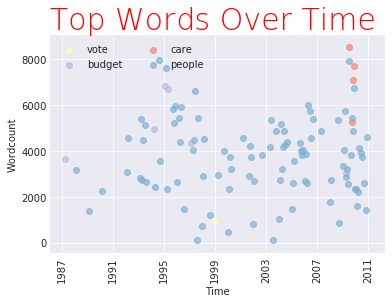

In [59]:
%matplotlib inline

# style
plt.style.use('seaborn-darkgrid') # this gives us a grid with a dark background.  you can play with this to change the style.
  
# create a color palette
palette = plt.get_cmap('Set3') # this tells matplotlib what colors to use.  you can play with this to change the colors.
 
# multiple line plot
num=0

# this is the for loop that creates multiple plots
for word in set(top_words_over_time['word']):
    num+=1 # for each new word, the counter 'num' changes 
    plt.scatter(top_words_over_time.loc[top_words_over_time['word'] == word, 'month_year'], # x axis 
             top_words_over_time.loc[top_words_over_time['word'] == word, 'count'],  # y axis
             color=palette(num), linewidth=1, alpha=0.7, label=word) # num tells the plot to choose a different color this time

# Add legend
plt.legend(loc=2, ncol=2)
plt.xticks(rotation=90)
 
# Add titles
plt.title("Top Words Over Time", loc='left', fontsize=30, fontweight=0, color='Red')
plt.xlabel("Time")
plt.ylabel("Wordcount")

plt.show()



We have a good representation of wordcount here.  Although I want to emphasize that we are, technically, *doing everything wrong*.  It is almost never the case that the most frequent words are the most interesting.  

In this case, however, we've used stopwording to chisel away at the word list, until we have a pretty interesting story -- the decline of the president, the rise of the people; a shift from the "world" to "care."  It's the start of something -- but I'm not sure what it means yet!

That's why, in your assignments in previous weeks, we've asked you to use a controlled vocabulary to choose particular words.  You could use such a controlled vocabulary to refine the chart above, for example, to zoom in on the conversation about the environment.

There's another problem too, however.  The numbers in this chart are deceptive; if we were measuring them over decades ,they would be even more problematic.  There's just a lot of noise -- look at all those colors jumbled together.  This is an excellent case for using _averages_ over time -- moving from month to year -- and _proportions_ -- measuring word count against how many words were spoken in a period.  

We won't take any more averages right now -- although above, when we "groupby" month_year and then take the sum for that period, you could easily switch in year for month_year and/or "mean" for "sum," and play with what would happen then.  

Instead, we'll look at taking wordcounts as a proportion rather than a raw count.  Above, where we counted the number of words per date, we saw that there was a huge variation in words spoken per day.  The numbers we've charted per word are meaningless without some sense of how they represent other variations in speaking.  

One of the great tools for measuring change over time is to "normalize" word counts.  Simply put, we take the ratio: number of times the word "bill" appears vs number of words spoken in that period.

# Get proportions

Let's quickly think about measuring the proportions of each word over time.  


Now with our previous work, we have the materials for calculating proportion.

We have word_per_year_counts, as well as the total count of words per each year.

In [60]:
word_per_year_counts.head()

,word,count,month_year
0,the,162558,1995-07-01
1,to,87450,1995-07-01
2,of,76171,1995-07-01
3,and,61234,1995-07-01
4,that,47961,1995-07-01


In [61]:
just_counts.head()

,month_year,word_count,year
0,1987-01-01,1186313,1987
1,1987-02-01,1025105,1987
2,1987-03-01,1996218,1987
3,1987-04-01,1958265,1987
4,1987-05-01,2194226,1987


To put the two dataframes together, we need to perform a merge -- technically an "inner join."  You can picture an inner join like the area at the center of a venn diagram: in this case, both dataframes share the column month_year.  So we can tell python to paste them together using month_year.

In [62]:
word_proportions = pd.merge(just_counts, word_per_year_counts,how='inner', left_on='month_year', right_on='month_year')

word_proportions.head()

,month_year,word_count,year,word,count
0,1987-01-01,1186313,1987,the,78700
1,1987-01-01,1186313,1987,of,43604
2,1987-01-01,1186313,1987,to,38530
3,1987-01-01,1186313,1987,and,29891
4,1987-01-01,1186313,1987,in,22515


Now that we have the count of each word ("count") in the same dataframe as the count of all words per month_year ("word_count"), we can find out what proportion of speech per month_year is represented by each word.

In [63]:
word_proportions['proportion'] = word_proportions['count']/word_proportions['word_count']
word_proportions

,month_year,word_count,year,word,count,proportion
0,1987-01-01,1186313,1987,the,78700,0.066340
1,1987-01-01,1186313,1987,of,43604,0.036756
2,1987-01-01,1186313,1987,to,38530,0.032479
3,1987-01-01,1186313,1987,and,29891,0.025197
4,1987-01-01,1186313,1987,in,22515,0.018979
...,...,...,...,...,...,...
13545,2010-12-01,2103020,2010,It,4674,0.002223
13546,2010-12-01,2103020,2010,what,4635,0.002204
13547,2010-12-01,2103020,2010,people,4593,0.002184
13548,2010-12-01,2103020,2010,Senator,4160,0.001978


Notice that the numbers in the "proportion" column are really small.  They represent proportions: all the counts for every word in 2007-01 would add up to 1.  We can represent them as percentages: "speaker" appears 3.14% of the time.  Knowing what the proportion means and talking about it accurately is an important part of doing data science correctly.  
Understanding proportion also means that we will take steps to make sure that any graph based on proportions represents those measures as percentages and labels them correctly.

We're getting close.  But now we need to filter the database for top words.  

The dataframe word_proportions currently contains the measures of the top 50 words for each period.  

We only want measures over time of only the ten top words, contained in top_words2.  Do you remember how we filter for those words?

In [64]:
top_words_over_time_proportion = pd.DataFrame()

for word in set(word_proportions['word']): # cycling through the unique words in the dataframe above
    if word in top_words3: # if the word is a top word
        top_words_over_time_proportion = top_words_over_time_proportion.append(word_proportions.loc[word_proportions['word'] == word]) #grab the row.
        
        
top_words_over_time_proportion

,month_year,word_count,year,word,count,proportion
6644,1998-12-01,389799,1998,vote,922,0.002365
698,1988-02-01,1549931,1988,people,3140,0.002026
1199,1989-02-01,835159,1989,people,1382,0.001655
1745,1990-02-01,1244192,1990,people,2248,0.001807
2798,1992-02-01,1659500,1992,people,3059,0.001843
...,...,...,...,...,...,...
12544,2009-04-01,1390800,2009,budget,3019,0.002171
12691,2009-07-01,3785271,2009,care,8497,0.002245
12840,2009-10-01,2072728,2009,care,5268,0.002542
12878,2009-11-01,1806985,2009,care,7095,0.003926


## Line chart with proportions

There are only a few ways that the proportion chart differs from the raw count chart.  Can you find them all?

In [65]:
# convert month-year back to date format for easier plotting
top_words_over_time_proportion['month_year'] =top_words_over_time_proportion.month_year.values.astype('datetime64[M]')
top_words_over_time_proportion

,month_year,word_count,year,word,count,proportion
6644,1998-12-01,389799,1998,vote,922,0.002365
698,1988-02-01,1549931,1988,people,3140,0.002026
1199,1989-02-01,835159,1989,people,1382,0.001655
1745,1990-02-01,1244192,1990,people,2248,0.001807
2798,1992-02-01,1659500,1992,people,3059,0.001843
...,...,...,...,...,...,...
12544,2009-04-01,1390800,2009,budget,3019,0.002171
12691,2009-07-01,3785271,2009,care,8497,0.002245
12840,2009-10-01,2072728,2009,care,5268,0.002542
12878,2009-11-01,1806985,2009,care,7095,0.003926


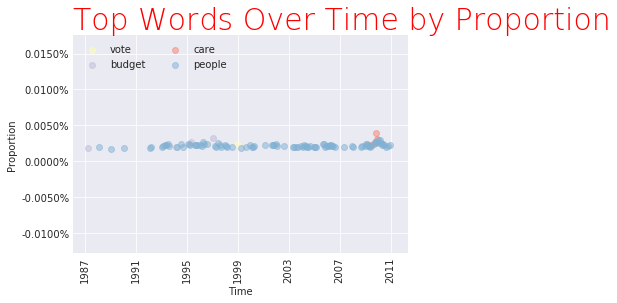

In [66]:
plt.clf() # <-- clears out the earlier plot

%matplotlib inline
import matplotlib.ticker as ticker # <--- notice that we're importing a new ticker function 

# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set3')
 
# multiple line plot
num=0


for word in set(top_words_over_time_proportion['word']):
    num+=1
    plt.scatter(top_words_over_time_proportion.loc[top_words_over_time_proportion['word'] == word, 'month_year'], # x axis 
             top_words_over_time_proportion.loc[top_words_over_time_proportion['word'] == word, 'proportion'],  # y axis
             color=palette(num), linewidth=1, alpha=0.5, label=word)

# Add legend
plt.legend(loc=2, ncol=2)
plt.xticks(rotation=90)
 
# Add titles
plt.title("Top Words Over Time by Proportion", loc='left', fontsize=30, fontweight=0, color='red')
plt.xlabel("Time")
plt.ylabel("Proportion") # <--- Notice that I've re-labeled the title and y-axis
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter()) # <--- This tells matplotlib that we're dealing with percentages
#plt.tick_params(axis='both',labelsize=14)

plt.show()


Notice that there's appears to be a much narrower range of variation in the Proportion plot over the Raw Count plot.  A few words' variation may stand out (depending on what time range you're looking at) -- "order" and "care" stand out for me, for instance -- as having greater variation than the other words, which mostly stay the same.  The outliers give us an important clue about historical change: something was going on with "order"!  

If we were writing a paper about this data, we would know to follow the data into the use of "order" in 2011 to figure out why order was being talked about relative to the normal distribution of that word.  That knowledge -- in turn -- would help us to answer the historical question: what was changing about debates in Congress during this time? 

We can learn from this exercise how important it is to "normalize" the data by treating word counts as a percentage of a changing number of words spoken over time.  Don't forget to normalize the wordcounts in your data challenges!

# Assignment

Group the data by one field then another. Create two plots, labeled according to the grouping strategy. Upload the plots to canvas.